<a href="https://colab.research.google.com/github/PsorTheDoctor/deep-neural-nets/blob/main/week3_multilayer_perceptron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Multilayer perceptron

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

In [ ]:
class Cifar10(torchvision.datasets.CIFAR10):
  def __init__(self, train: bool):
    super().__init__(root='~/data', train=train, download=True)
    self.data = self.data.astype(np.float32) / 255 - 0.5

  def __getitem__(self, idx):
    return self.data[idx], self.targets[idx]

data_train = Cifar10(train=True)
data_train, data_valid = torch.utils.data.random_split(data_train, (45000, 5000))
data_test = Cifar10(train=False)

In [3]:
kwargs = {'batch_size': 100, 'num_workers': 2}
loader_train = torch.utils.data.DataLoader(data_train, **kwargs, shuffle=True)
loader_valid = torch.utils.data.DataLoader(data_valid, **kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **kwargs)

## Challenge
* Build a Multi Layer Perceptron, MLP, with one ReLU-activated hidden layer.
* Use the validation set to inform e.g. number of hidden neurons.
* When you're satisfied, then, use the test set to get an  
unbiased estimate of your models performance on the real data distribution.

In [31]:
# Make model function or class. See nn.Module or nn.Sequential
# Remember to shape the input to (N, d_data). See nn.Flatten or .view()
class MLP(nn.Module):
  def __init__(self, n_hidden_units):
    super(MLP, self).__init__()
    self.model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(32 * 32 * 3, n_hidden_units),
        nn.ReLU(),
        nn.Linear(n_hidden_units, 10)
    )

  def forward(self, x):
    result = self.model(x)
    return result

In [25]:
all_losses, all_accuracies = {}, {}
best_accuracy = 0
best_model = None

In [41]:
device = torch.device('cuda')
n_hidden_neurons = 500
model = MLP(n_hidden_neurons).to(device)
opt = torch.optim.SGD(model.parameters(), lr=5e-2)

train_losses, train_accuracies = [], []
valid_losses, valid_accuracies = [], []

for epoch in tqdm(range(50)):
  # Train
  epoch_losses = []
  correct, total = 0, 0
  for x, y in loader_train:
    x, y = x.to(device), y.to(device)
    logits = model(x)  # logits: common name for the output before softmax activation
    log_probs = F.log_softmax(logits, dim=1)  # numerically stable version of log(softmax(logits))
    loss = F.nll_loss(log_probs, y)  # negative log likelihood loss
    # or just: loss = F.cross_entropy(logits, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_losses.append(loss.item())
    total += len(x)
    correct += (torch.argmax(logits, dim=1) == y).sum().item()
  train_loss = np.mean(epoch_losses)
  train_accuracy = correct / total

  # Valid
  for x, y in loader_valid:
    x, y = x.to(device), y.to(device)
    logits = model(x)
    log_probs = F.log_softmax(logits, dim=1)
    loss = F.nll_loss(log_probs, y)

    opt.zero_grad()
    loss.backward()
    opt.step()

    epoch_losses.append(loss.item())
    total += len(x)
    correct += (torch.argmax(logits, dim=1) == y).sum().item()
  valid_loss = np.mean(epoch_losses)
  valid_accuracy = correct / total

  if valid_accuracy > best_accuracy:
    best_accuracy = valid_accuracy
    best_model = copy.deepcopy(model), n_hidden_neurons, epoch

  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accuracies.append(train_accuracy)
  valid_accuracies.append(valid_accuracy)

all_losses[n_hidden_neurons] = train_losses, valid_losses
all_accuracies[n_hidden_neurons] = train_accuracies, valid_accuracies

  0%|          | 0/50 [00:00<?, ?it/s]

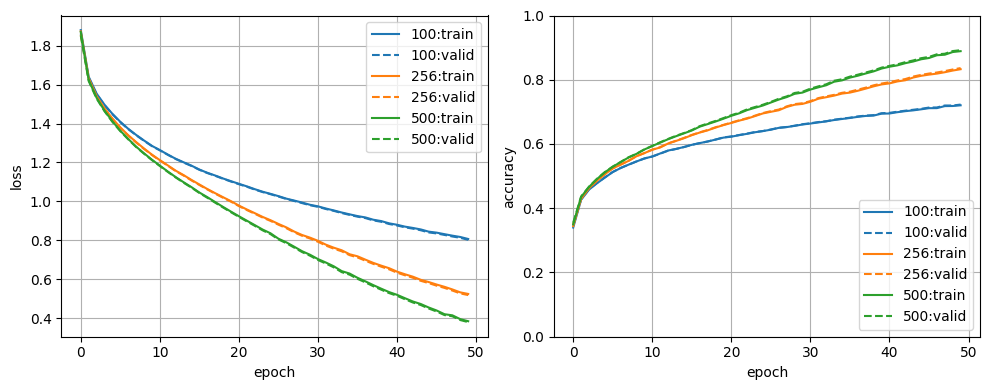

In [42]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.xlabel('epoch')
plt.ylabel('loss')
for n, (train_losses, valid_losses) in all_losses.items():
  p = plt.plot(train_losses, label=f'{n}:train')
  plt.plot(valid_losses, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim(0, 1)
for n, (train_accuracies, valid_accuracies) in all_accuracies.items():
  p = plt.plot(train_accuracies, label=f'{n}:train')
  plt.plot(valid_accuracies, label=f'{n}:valid', ls='--', c=p[0].get_color())
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [43]:
model, n_hidden_neurons, epoch = best_model
print(f'best val accuracy: {best_accuracy:.2f} with {n_hidden_neurons} hidden neurons after {epoch} epoch')

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for x, y in loader_test:
    x, y = x.to(device), y.to(device)
    x_pred = model(x)
    _, y_pred = torch.max(x_pred.data, 1)
    total += y.size(0)
    correct += (y_pred == y).sum().item()

print(f'Test accuracy: {correct / total}')

best val accuracy: 0.89 with 500 hidden neurons after 49 epoch
Test accuracy: 0.5451
